# Semimetal de Weyl deformado

En esta sección se presenta el resultado de nuestra investigación, el cual es la introducción perturbación de nuestro semimetal de Weyl de manera mécanica. 

In [1]:
from pylab import *
mpl.rcParams.update({'font.size':18})

from plotly.subplots import make_subplots

import plotly.graph_objects  as go
import plotly.figure_factory as ff

from pythtb import * # import TB model class

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
import glob
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
mpl.rcParams.update({'font.size': 22, 'text.usetex': True})
mpl.rcParams.update({'axes.linewidth':1.5})
mpl.rcParams.update({'axes.labelsize':'large'})
mpl.rcParams.update({'xtick.major.size':12})
mpl.rcParams.update({'xtick.minor.size':6})
mpl.rcParams.update({'ytick.major.size':12})
mpl.rcParams.update({'ytick.minor.size':6})
mpl.rcParams.update({'xtick.major.width':1.5})
mpl.rcParams.update({'xtick.minor.width':1.0})
mpl.rcParams.update({'ytick.major.width':1.5})
mpl.rcParams.update({'ytick.minor.width':1.0})

---
# Hamiltoniano del sistema


\begin{eqnarray}
H(k) = \left[
\begin{array}{cc}
\frac{\gamma }{2}(e^{ik_xa}+e^{-ik_xa}-e^{ik_0a}-e^{-ik_0a})-\frac{t}{i}(e^{ik_za}-e^{-ik_za}) & 
-\frac{m}{2}(4-e^{ik_ya}-e^{-ik_ya}-e^{ik_za}-e^{-ik_za})+t_x(e^{ik_xa}+e^{-ik_xa}-e^{ik_0a}-e^{-ik_0a})+t(e^{ik_ya}-e^{-ik_ya})\\
-\frac{m}{2}(4-e^{ik_ya}-e^{-ik_ya}-e^{ik_za}-e^{-ik_za})+t_x(e^{ik_x}+e^{-ik_xa}-e^{ik_0a}-e^{-ik_0a})-t(e^{ik_ya}-e^{-ik_ya})&
\frac{\gamma }{2}(e^{ik_xa}+e^{-ik_xa}-e^{ik_0a}-e^{-ik_0a})+\frac{t}{i}(e^{ik_za}-e^{-ik_za})
\end{array}
\right]
\end{eqnarray}



In [5]:
from palettable.cubehelix import Cubehelix
palette = Cubehelix.make(start=-0.5, rotation=0.3,reverse=True,n=10)


In [6]:
#Parámetros
a  = 1.0
k_0= pi/2
   
tx = 1   
t  = 1
m  = 2*t
γ  = 0

A_x= 0.0
A_y= +0.0
A_z= 0.0

##################----------------Inicia TB----------------##################
lat= [[a,0,0],[0,a,0],[0,0,a]]
orb= [[0,0,0],[1/2,1/2,1/2]] #H, solo los sitios A[000] B1/2[111]

WSH = tb_model(3,3,lat,orb)

#DIAGONAL
#γ*(cos(k_x)-cos(k_0))-2*t*sin(k_z)
# γ[coskx]
WSH.set_hop( γ/2, 0, 0,[1,0,0])#de que sitio a que sitio va el hoping, [la exp que lleva ese parametro], Conjugado ya no es 
# -2tsinkz                                #necesario, está implícito porque es Hermitiano.
WSH.set_hop(-t/1J, 0, 0,[0,0,1])

#Hermitiano [1,1]
WSH.set_hop(γ/2, 1, 1,[1,0,0])
WSH.set_hop(t/1J, 1, 1,[0,0,1])

WSH.set_onsite([-γ*cos(k_0),-γ*cos(k_0)]) # No hay hooping, es energia

#FUERA DE LA DIAGONAL

# -[m*(2-cos(k_y)-cos(k_z))+2*tx*(cos(k_x)-cos(k_0))]+2J*t*sin(k_y)
#  2txcosk_0
WSH.set_hop(-2*m+2*(tx)*cos(k_0), 0, 1,[0,0,0]) 
#mcosky+ 2itsin(ky)
WSH.set_hop(m/2+t, 0, 1,[0, 1,0]) 
WSH.set_hop(m/2-t, 0, 1,[0,-1,0])
# WSH.set_hop(m/2-t, 1, 0,[0,+1,0])
# mcoskz
WSH.set_hop(m/2, 0, 1,[0,0,1]) 
WSH.set_hop(m/2, 0, 1,[0,0,-1])
# tx(coskx)
WSH.set_hop(-tx+A_x, 0, 1,[1,0,0]) 
WSH.set_hop(-tx+A_x, 0, 1,[-1,0,0])

# Introducción del Strain en el Hamiltoniano



Los hopping los modificaremos de la siguiente forma.
\begin{align}
t_{ij} = t^0_{ij}e^{\beta(1-r_{ij}/a_{\text{nn}})}
\end{align}
donde $a_{\text{nn}}$ es la distancia de equilibrio.

In [7]:
"""La siguiente función permite obtener la DOS usando Funciones de Green"""
Et=linspace(-10,13,1001)
def G(Edos):
    GreenP = []
    f      = 0.01 #al aumentarlo, mejora la fidelidad al hsitograma
    
    for i in Et:
        g  = sum(1/(i+f*1J-Edos))
        GreenP.append(g)
    GreenM = []

    for i in Et:
        g  = sum(1/(i-f*1J-Edos))
        GreenM.append(g)
    
    GIP  = -imag(GreenP)
    GRP  = real(GreenP)
    
    return GIP, GRP

In [8]:
"""Construccion de la malla para un sistema de PR*PR puntos k"""
PR    = 101
kx,ky = linspace(0,1,PR),linspace(0,1,PR)
KX,KY = meshgrid(kx,ky)
KX,KY = KX.flatten(),KY.flatten()
Kf         = column_stack((KX,KY))
# solve the model on this mesh
# Ekf=N_WSM.solve_all(Kf)
# # flatten completely the matrix
# Ekf=Ekf.flatten()


In [9]:
""""La siguiente función permite aplicar el strain de una funcion u(Y) al sistema que es una malla de PR*PR puntos k
Los argumentos son: epsilon, β, la funcion de deformación y el plano en Z que se estudia"""

def StrainKF(eps,beta,funstrain,z):
    
    uY   = (eps/L)*funstrain
    Ynew = Y + uY
    
    pares=arange(0,2*L,2)
    nones=arange(3,2*L,2)

    for l in range(L-1):
        hop1 = (m/2+t)*exp(beta*(1 - (Ynew[nones[l]]-Ynew[pares[l]])/((Y[nones[l]]-Y[pares[l]]))  ))
        NY_WSM.set_hop(hop1,pares[l],nones[l],[0,0,0],mode='reset')
    for p in pares[1:]:
        hop2 = (m/2-t)*exp(beta*(1 - (Ynew[p]-Ynew[p-1])/(Y[p]-Y[p-1])  ))
        NY_WSM.set_hop(hop2,p,p-1,[0,0,0],mode='reset')
        
#     k = [[0.0,z],[0.5,z],[1,z]] # Punto por los cuales que quiero que pase. Son los punto de al simetria
#                                  #unidades en unidades de V de red 1=2pi/a
#     k_label=[r"$-X$",r"$\Gamma$",r"$X$"]
#     (k_vec,k_dist,k_node)=NY_WSM.k_path(k,501,report=False)
    Ek,ψ =NY_WSM.solve_all(Kf,eig_vectors=True)
#     (k_vec,k_dist,k_node)=NZ_WSM.k_path(k,501,report=False)
#     Ek1,ψ1 =NZ_WSM.solve_all(k_vec,eig_vectors=True)
#     fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(16,8),
#                        gridspec_kw = {'wspace':0.2, 'hspace':0.4, 'width_ratios': [1,1]})
#     for l in range(len(Ek)):
#          a=ax[0].plot(k_dist,Ek[l,:], c='black', alpha=0.6)
#          b=ax[1].plot(k_dist,Ek1[l,:], c='purple', alpha=0.6)
    return Ek, ψ, max(uY)

In [10]:
""""La siguiente función permite aplicar el strain de una funcion u(Y) al sistema que es una maya de PR*PR puntos k
Los argumentos son: epsilon, β, la funcion de deformación y el plano en Z que se estudia.

A diferencia de la anterior en este el numero de puntos k es de 501"""

def Strain(eps,beta,funstrain,z):
    
    uY   = (eps/L)*funstrain
    Ynew = Y + uY
    
    pares=arange(0,2*L,2)
    nones=arange(3,2*L,2)

    for l in range(L-1):
        hop1 = (m/2+t)*exp(beta*(1 - (Ynew[nones[l]]-Ynew[pares[l]])/((Y[nones[l]]-Y[pares[l]]))  ))
        NY_WSM.set_hop(hop1,pares[l],nones[l],[0,0,0],mode='reset')
    for p in pares[1:]:
        hop2 = (m/2-t)*exp(beta*(1 - (Ynew[p]-Ynew[p-1])/(Y[p]-Y[p-1])  ))
        NY_WSM.set_hop(hop2,p,p-1,[0,0,0],mode='reset')
        
    k = [[0.0,z],[0.5,z],[1,z]] # Punto por los cuales que quiero que pase. Son los punto de al simetria
                                 #unidades en unidades de V de red 1=2pi/a
    k_label=[r"$-X$",r"$\Gamma$",r"$X$"]
    (k_vec,k_dist,k_node)=NY_WSM.k_path(k,501,report=False)
    Ek,ψ =NY_WSM.solve_all(k_vec,eig_vectors=True)
#     (k_vec,k_dist,k_node)=NZ_WSM.k_path(k,2001,report=False)
#     Ek1,ψ1 =NZ_WSM.solve_all(k_vec,eig_vectors=True)
#     fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(16,8),
#                        gridspec_kw = {'wspace':0.2, 'hspace':0.4, 'width_ratios': [1,1]})
#     for l in range(len(Ek)):
#          a=ax[0].plot(k_dist,Ek[l,:], c='black', alpha=0.6)
#          b=ax[1].plot(k_dist,Ek1[l,:], c='purple', alpha=0.6)
    return Ek, ψ, max(uY)

    

In [11]:
"""Esta función permite obtner el IPR dando los eigenestados del sistema"""


def IPR(ψk):
    nBands,nkpts,nsites= shape(ψk)
    I     = []
    ik =nkpts//2
    prob=0
    for i in range((nsites)):
        prob +=( conj(ψk[i][ik])*ψk[i][ik])**4
        suma2=  vdot(ψk[i][ik],ψk[i][ik])**2
        
    I=array((prob/suma2).real)
    return I




In [28]:
"""Construcción del sistema finito"""
L=101
NY_WSM=WSH.cut_piece(L,1,glue_edgs=False) #numero de reps, en la direccion 0x,1y,2z, mi sistema se redujo dimensionalmente                                        #modo rebanada de jamón
NYN_WSM=WSH.cut_piece(L,1,glue_edgs=False)

In [29]:
"""Obtención de las coordenadas de los motivos de la red (cubica)"""

X,Y,Z = dot( NY_WSM.get_orb(), NY_WSM.get_lat() ).T

eps=15
n=12
beta=2
funstrain=cos(n*pi*Y/L)
uY   = (eps/L)*funstrain
Ynew = Y + uY

In [30]:
Ek6s,ψ6s,max_u6s= Strain(eps,beta, funstrain,0.0) 
z=0
k = [[0.0,z],[0.5,z],[1,z]] # Punto por los cuales que quiero que pase. Son los punto de al simetria
                                 #unidades en unidades de V de red 1=2pi/a
k_label=[r"$-X$",r"$\Gamma$",r"$X$"]

(k_vec,k_dist,k_node)=NYN_WSM.k_path(k,501,report=False)
Ek0,ψ0 =NYN_WSM.solve_all(k_vec,eig_vectors=True)


## Comparación de un sistema tipico de WSM tipo I no perturbado con un sistema perturbado.

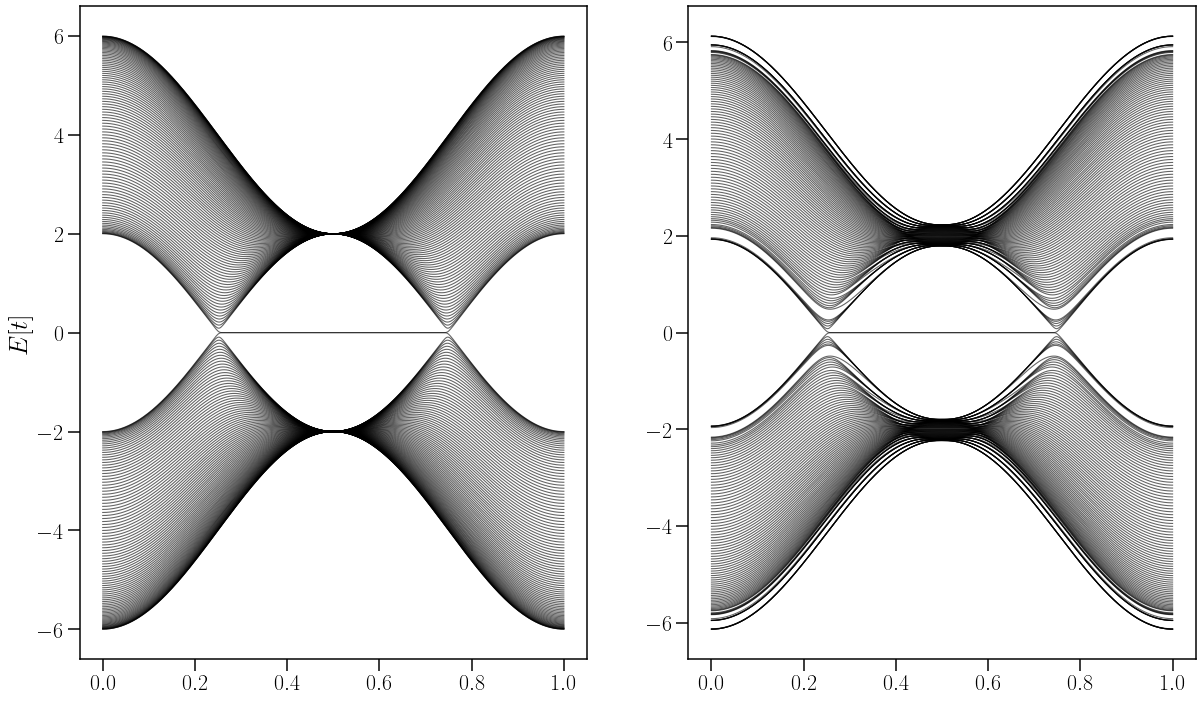

In [31]:
fig,ax  = plt.subplots(ncols=2,nrows=1,figsize=(20,12),
                       gridspec_kw = {'wspace':0.2, 'hspace':0.4, 'width_ratios': [1,1]})
k_dist=linspace(0,1,501)
for n in range(0, len(Ek0)):
    
    ax[0].plot(k_dist,Ek0[n,:], c='black', alpha=0.6,linewidth=1.1) #la long de Ek fin tiene todo
    ax[1].plot(k_dist,Ek6s[n,:], c='black', alpha=0.6,linewidth=1.1)



ax[0].set_ylabel(r"$E[t]$",fontsize=26)
ax[0].set_ylabel(r"$E[t]$",fontsize=26)

savefig("LatChemStrai_cos(na)_WSM_TII.pdf", bbox_inches="tight")

In [32]:
prob=IPR(ψ6s)
shape(prob)

prob

array([0.125, 1.   , 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.125,

## Ubicación de los arcos de Fermi: estados de superficie o borde

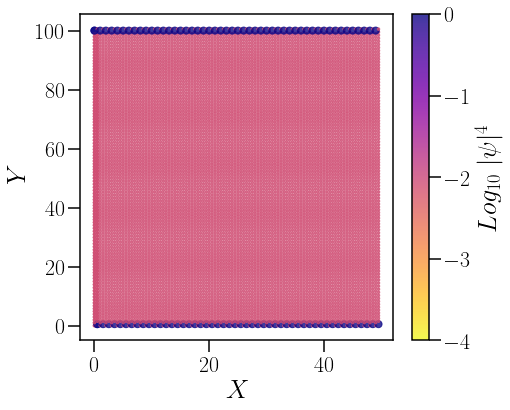

In [33]:
fig,ax = plt.subplots(figsize=(7,6))
colores = ["r", "b", "g"]
# ax.scatter(X,Y,c="blue")000
triang = ax.scatter(X,Ynew,c=log(prob),cmap=cm.plasma_r,s=prob*50, vmin=-4, vmax=log(1), alpha=0.8)
for i in range(50):
    ax.scatter(X+i,Ynew,c=log(prob),cmap=cm.plasma_r,s=prob*50, vmin=-4, vmax=log(1), alpha=0.8)

plt.colorbar(triang,ax=ax,label="$Log_{10}\;|\psi|^4$")
ax.set_ylabel("$Y$")
ax.set_xlabel("$X$")
savefig("UbiFermiArcs.pdf", bbox_inches= "tight")

En la figura anterior se puede denotar que los estados electrónicos más localizados se encuentran en los bordes del material. De estudios anteriores sabemos que los arcos de Fermi son los estados con mayor localuzación, por lo que podemos concluir que dichos estados de superficie corresponden a los arcos de Fermi.

## Evolución del sistema perturbado al aumentar el parámetro de deformación $n$

In [34]:

%%time
e=15
Ek1,ψ1,max_u1= Strain(0,2, cos(2*pi*Y/L),0.0) 
Ek2,ψ2,max_u2= Strain(e,2, cos(2*pi*Y/L),0.0) 
Ek3,ψ3,max_u3= Strain(e,2, cos(4*pi*Y/L),0.0) 
Ek4,ψ4,max_u4= Strain(e,2, cos(6*pi*Y/L),0.0) 
Ek5,ψ5,max_u5= Strain(e,2, cos(10*pi*Y/L),0.0) 
Ek6,ψ6,max_u6= Strain(e,2, cos(12*pi*Y/L),0.0) 

CPU times: user 1min 24s, sys: 584 ms, total: 1min 24s
Wall time: 1min 24s


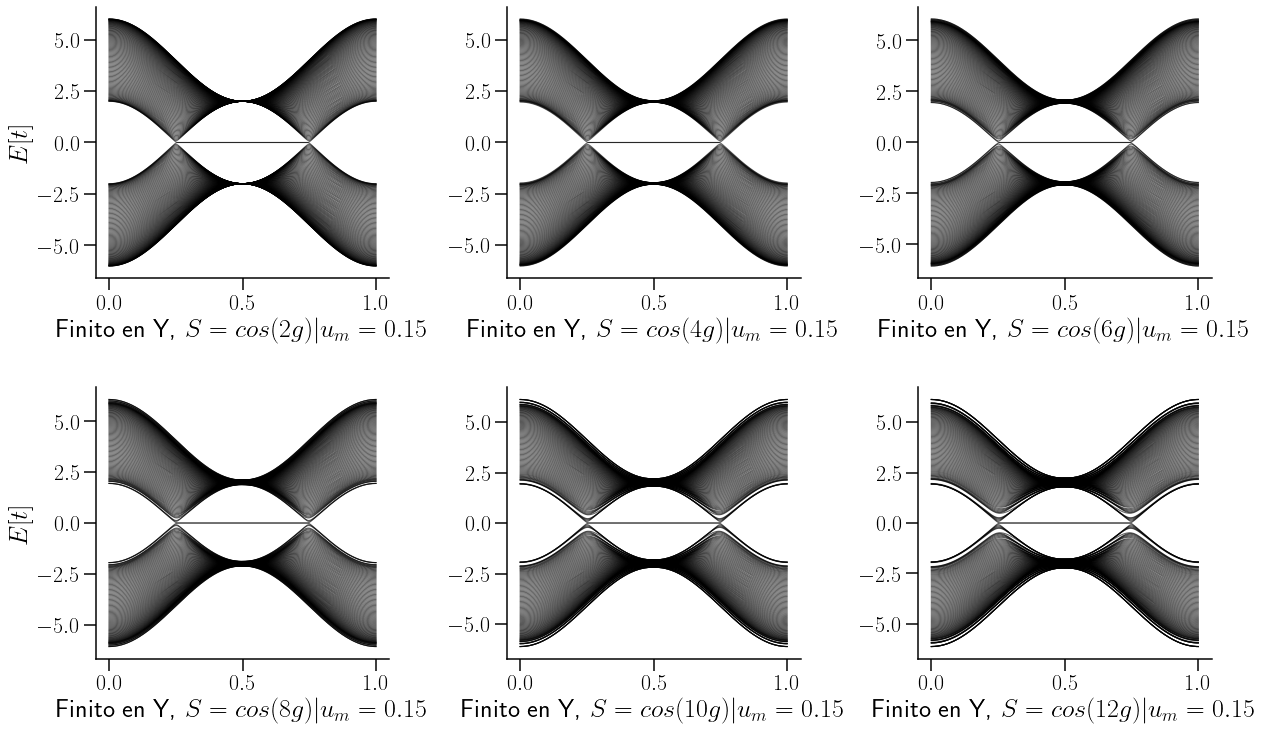

In [35]:
fig,ax  = plt.subplots(ncols=3,nrows=2,figsize=(20,12),
                       gridspec_kw = {'wspace':0.4, 'hspace':0.4, 'width_ratios': [1,1,1]})
k_dist=linspace(0,1,501)
for n in range(0, len(Ek1)):
    
    ax[0,0].plot(k_dist,Ek1[n,:], c='black', alpha=0.6,linewidth=1.1) #la long de Ek fin tiene todo
    ax[0,1].plot(k_dist,Ek2[n,:], c='black', alpha=0.6,linewidth=1.1)
    ax[0,2].plot(k_dist,Ek3[n,:], c='black', alpha=0.6,linewidth=1.1)#la long de Ek fin tiene todo
    ax[1,0].plot(k_dist,Ek4[n,:], c='black', alpha=0.6,linewidth=1.1) 
    ax[1,1].plot(k_dist,Ek5[n,:] ,c='black', alpha=0.6,linewidth=1.1 )
    ax[1,2].plot(k_dist,Ek6[n,:], c='black', alpha=0.6,linewidth=1.1)
    
for i in range(0,2):
    for j in range(0,3):
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
#         ax[i,j].set_ylim(-1,1)

ax[0,0].set_ylabel(r"$E[t]$",fontsize=26)
ax[1,0].set_ylabel(r"$E[t]$",fontsize=26)

ax[0,0].set_xlabel(r"Finito en Y, $S=cos(2g)|u_m={0}$".format(0.15),fontsize=26)
ax[0,1].set_xlabel(r"Finito en Y, $S=cos(4g)|u_m={0}$".format(0.15),fontsize=26)
ax[0,2].set_xlabel(r"Finito en Y, $S=cos(6g)|u_m={0}$".format(0.15),fontsize=26)
ax[1,0].set_xlabel(r"Finito en Y, $S=cos(8g)|u_m={0}$".format(0.15),fontsize=26)
ax[1,1].set_xlabel(r"Finito en Y, $S=cos(10g)|u_m={0}$".format(0.15),fontsize=26)
ax[1,2].set_xlabel(r"Finito en Y, $S=cos(12g)|u_m={0}$".format(0.15),fontsize=26)
savefig("LatChemStrai_cos(na)_WSM_TII.pdf", bbox_inches="tight")

Se puede obseervar que conforme aumenta el parámetro de deformación se va abriendo un gap alrededor de los nodos de Weyl, y los estados alrededor de $k=$0.5 se van concentrando.

In [36]:
e=15
Ek1s,ψ1s,max_u1s= Strain(e,2, sin(2*pi*Y/L),0.0) #esp, beta, función de strain
Ek2s,ψ2s,max_u2s= Strain(e,2, sin(4*pi*Y/L),0.0) 
Ek3s,ψ3s,max_u3s= Strain(e,2, sin(6*pi*Y/L),0.0) 
Ek4s,ψ4s,max_u4s= Strain(e,2, sin(8*pi*Y/L),0.0) 
Ek5s,ψ5s,max_u5s= Strain(e,2, sin(10*pi*Y/L),0.0)
Ek6s,ψ6s,max_u6s= Strain(e,2, sin(12*pi*Y/L),0.0) 

In [37]:
Ek6s,ψ6s,max_u6s= StrainKF(e,2, sin(12*pi*Y/L),0.0) 
Ek0,ψ0,max_u0= StrainKF(0,2,sin(12*pi*Y/L),0.0) 

In [38]:

GStrain,GN= G(Ek6s),G(Ek0)

## ¿Cómo se ve afectada la densidad de estados?

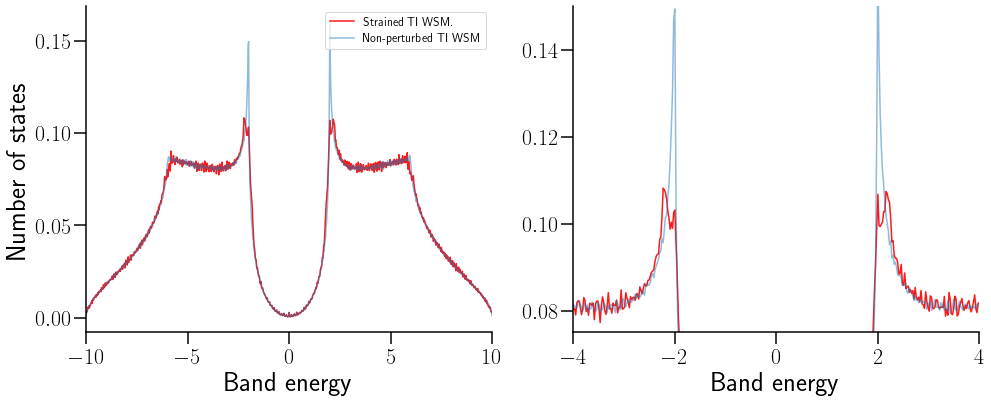

In [39]:
fig,ax  = plt.subplots(ncols=2,nrows=1,figsize=(16,6),
                       gridspec_kw = {'wspace':0.2, 'hspace':0., 'width_ratios': [1,1]})
Na=1/(101*101*100*6.27)
ax[0].plot(Et,GStrain[0]*Na,color="red", alpha=0.9,label="Strained TI WSM.")
ax[0].plot(Et,GN[0]*Na, alpha=0.5,label="Non-perturbed TI WSM")
ax[0].set_xlim(-10,10)
ax[0].legend(loc=0,fontsize=12)

ax[1].plot(Et,GStrain[0]*Na,color="red", alpha=0.9)
ax[1].plot(Et,GN[0]*Na, alpha=0.5)
a=4
ax[1].set_xlim(-a,a)
ax[1].set_ylim(0.075,0.15)
ax[1].set_xlabel("Band energy")
ax[0].set_xlabel("Band energy")
ax[0].set_ylabel("Number of states")
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
savefig("strainDOS-WMSTI.pdf",bbox_inches="tight")

La DOS pierde la singularidad de Van Hove, como consecuencia de la perturbación mecánica.

In [40]:
a=trapz(GStrain[0]/(101*101*100*6.27), Et)
a

1.0109347802613633

In [42]:
e=15
Ek1s,ψ1s,max_u1s= Strain(e,2, sin(2*pi*Y/L),0.0) #esp, beta, función de strain
Ek2s,ψ2s,max_u2s= Strain(e,2, sin(4*pi*Y/L),0.0) 
Ek3s,ψ3s,max_u3s= Strain(e,2, sin(6*pi*Y/L),0.0) 
Ek4s,ψ4s,max_u4s= Strain(e,2, sin(8*pi*Y/L),0.0) 
Ek5s,ψ5s,max_u5s= Strain(e,2, sin(10*pi*Y/L),0.0)
Ek6s,ψ6s,max_u6s= Strain(e,2, sin(12*pi*Y/L),0.0) 

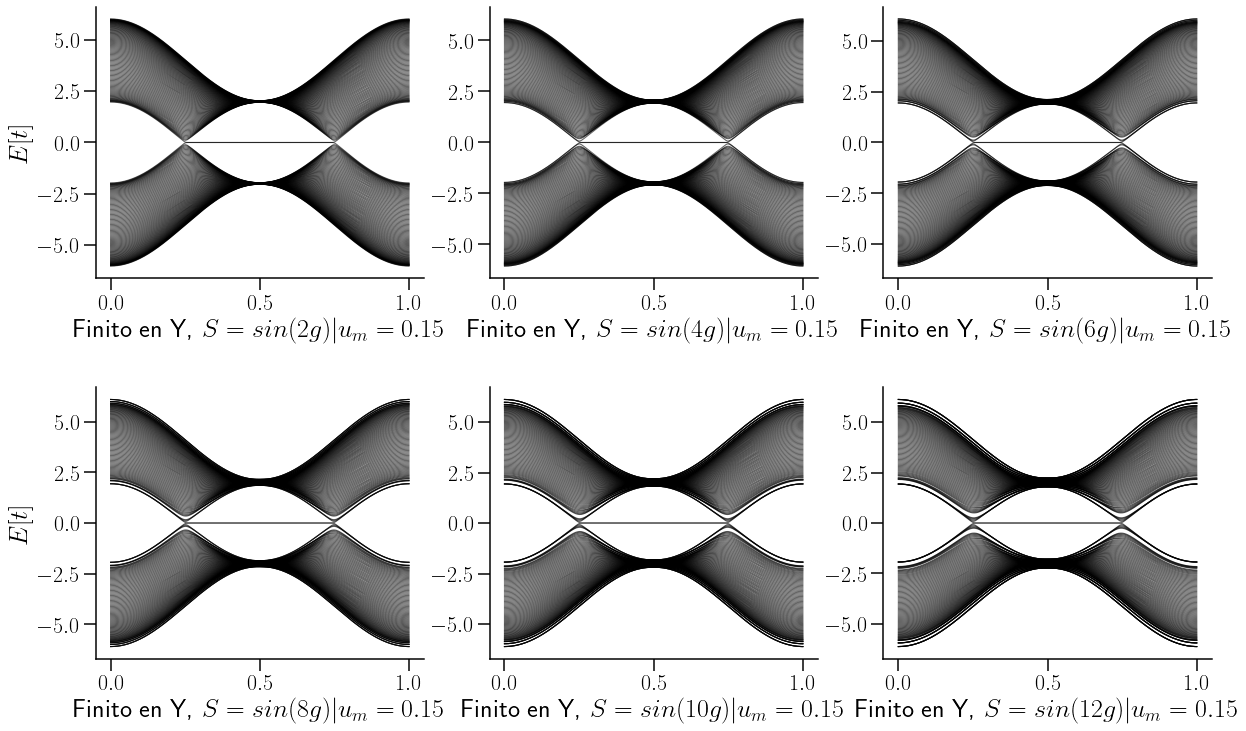

In [46]:
fig,ax  = plt.subplots(ncols=3,nrows=2,figsize=(20,12),
                       gridspec_kw = {'wspace':0.2, 'hspace':0.4, 'width_ratios': [1,1,1]})
for n in range(0, len(Ek1s)):
    
    ax[0,0].plot(k_dist,Ek1s[n,:], c='black', alpha=0.6,linewidth=1.1) #la long de Ek fin tiene todo
    ax[0,1].plot(k_dist,Ek2s[n,:], c='black', alpha=0.6,linewidth=1.1)
    ax[0,2].plot(k_dist,Ek3s[n,:], c='black', alpha=0.6,linewidth=1.1)#la long de Ek fin tiene todo
    ax[1,0].plot(k_dist,Ek4s[n,:], c='black', alpha=0.6,linewidth=1.1) 
    ax[1,1].plot(k_dist,Ek5s[n,:] ,c='black', alpha=0.6,linewidth=1.1 )
    ax[1,2].plot(k_dist,Ek6s[n,:], c='black', alpha=0.6,linewidth=1.1)
    
for i in range(0,2):
    for j in range(0,3):
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)

ax[0,0].set_ylabel(r"$E[t]$",fontsize=26)
ax[1,0].set_ylabel(r"$E[t]$",fontsize=26)

ax[0,0].set_xlabel(r"Finito en Y, $S=sin(2g)|u_m={0}$".format(0.15),fontsize=26)
ax[0,1].set_xlabel(r"Finito en Y, $S=sin(4g)|u_m={0}$".format(0.15),fontsize=26)
ax[0,2].set_xlabel(r"Finito en Y, $S=sin(6g)|u_m={0}$".format(0.15),fontsize=26)
ax[1,0].set_xlabel(r"Finito en Y, $S=sin(8g)|u_m={0}$".format(0.15),fontsize=26)
ax[1,1].set_xlabel(r"Finito en Y, $S=sin(10g)|u_m={0}$".format(0.15),fontsize=26)
ax[1,2].set_xlabel(r"Finito en Y, $S=sin(12g)|u_m={0}$".format(0.15),fontsize=26)
savefig("Strain_sin_WSM_TII.pdf", bbox_inches="tight")

No importa si la funciín de deformación es un $ \sin$ o $\cos$, el efecto sobre la estructura de bandas es el mismo, al igual que sobre la densidad de estados. Véase siguiente figura:

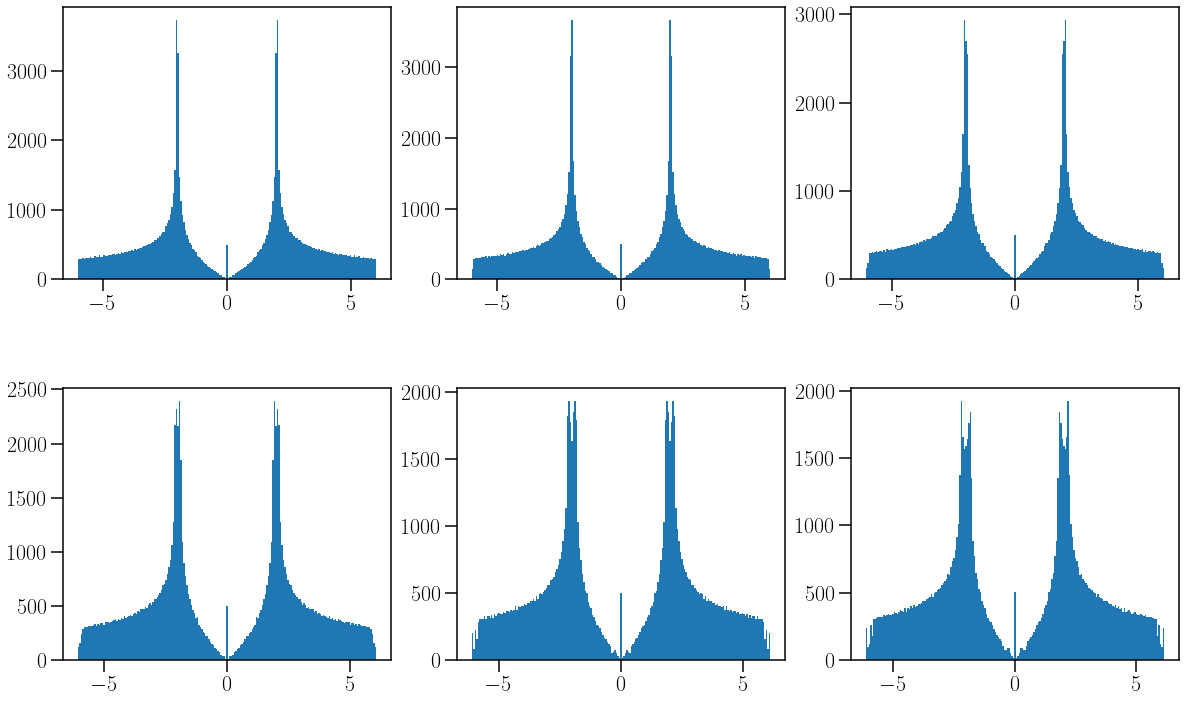

In [49]:
fig,ax  = plt.subplots(ncols=3,nrows=2,figsize=(20,12),
                       gridspec_kw = {'wspace':0.2, 'hspace':0.4, 'width_ratios': [1,1,1]})
a=201
 
ax[0,0].hist(Ek1.flatten(),a);
ax[0,1].hist(Ek2.flatten(),a);
ax[0,2].hist(Ek3.flatten(),a);
ax[1,0].hist(Ek4.flatten(),a);
ax[1,1].hist(Ek5.flatten(),a);
ax[1,2].hist(Ek6.flatten(),a);


# Obtención del IPR


In [52]:

Ik2=IPR(ψ2)

Ik4=IPR(ψ4)

Ik6=IPR(ψ6)
# Ik1s=IPR(ψ1s)
# Ik2s=IPR(ψ2s)
# Ik3s=IPR(ψ3s)
# Ik4s=IPR(ψ4s)
# Ik5s=IPR(ψ5s)
shape(Ik2)
# Ik6s=IPR(ψ6s)

(202,)

IndexError: too many indices for array

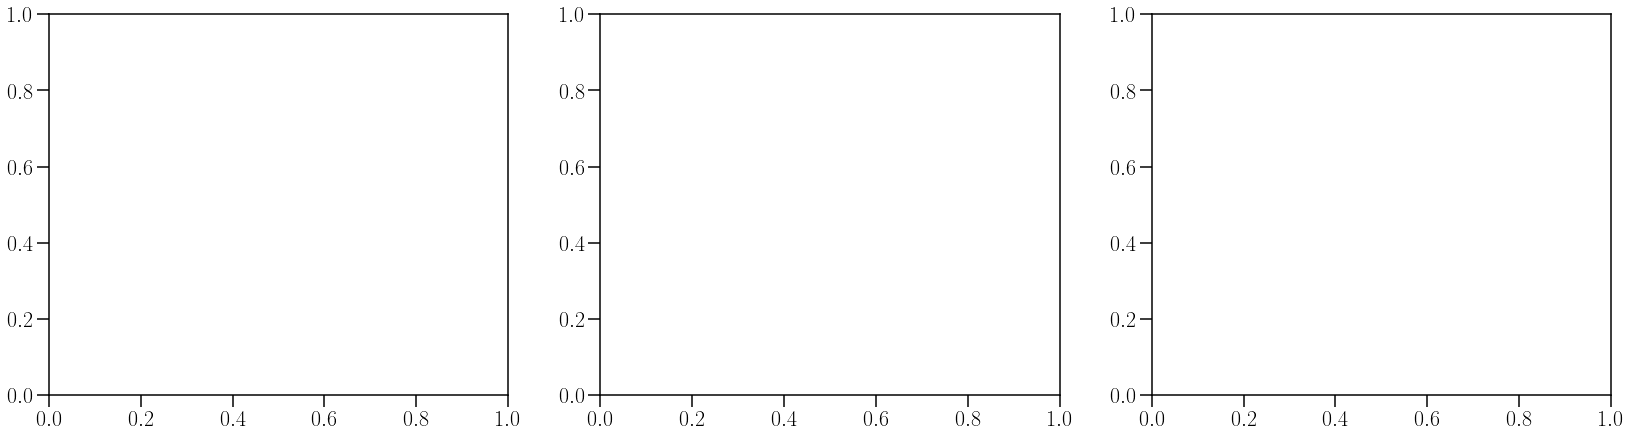

In [51]:
fig,ax  = plt.subplots(ncols=3,nrows=1,figsize=(28,7),
                       gridspec_kw = {'wspace':0.2, 'hspace':0.4, 'width_ratios': [1,1,1]})
k_dist=linspace(0,1,2001)
for n in range(0, len(Ek2)):
    
    Ekval=Ek2[n,:]
    amp  =Ik2[n]
    ax[0].scatter(k_dist,Ekval,c =log10(amp), vmin=-3,vmax=0, cmap = 'cubehelix_r',s = 0.5, alpha=0.5,rasterized=True)
    
    Ekval=Ek4[n,:]
    amp  =Ik4[n,:]
    ax[2].scatter(k_dist,Ekval,c =log10(amp), vmin=-3,vmax=0, cmap = 'cubehelix_r',s = 0.5, alpha=0.5,rasterized=True)
    
    Ekval=Ek6[n,:]
    amp  =Ik6[n,:]
    ax[1].scatter(k_dist,Ekval,c =log10(amp), vmin=-3,vmax=0, cmap = 'cubehelix_r',s = 0.5, alpha=0.5,rasterized=True)

        
for i in range(0,3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_ylim(-1.8,1.8)
#     ax[i].set_xlim(0,1)


ax[0].set_ylabel(r"$E[t]$",fontsize=26)
# ax[1,0].set_ylabel(r"$E[t]$",fontsize=26)

# ax[0,0].set_xlabel(r"Finito Y, $S=cos(2g)|u_m={0}$".format(max_u1s),fontsize=26)
# ax[0,1].set_xlabel(r"Finito Y, $S=cos(4g)|u_m={0}$".format(max_u2s),fontsize=26)
# ax[0,2].set_xlabel(r"Finito Y, $S=cos(6g)|u_m={0}$".format(max_u3s),fontsize=26)
# ax[1,0].set_xlabel(r"Finito Y, $S=cos(8g)|u_m={0}$".format(round(max_u4s,2)),fontsize=26)
# ax[1,1].set_xlabel(r"Finito Y, $S=cos(10g)|u_m={0}$".format(max_u5s),fontsize=26)
# ax[1,2].set_xlabel(r"Finito Y, $S=cos(12g)|u_m={0}$".format(max_u6s),fontsize=26)

savefig("LatchemStrain_IPR_cos_WSM_TII.pdf", bbox_inches="tight")

In [145]:
%matplotlib inline

In [117]:
k_dist=linspace(0,1,10201)
len(k_dist)

10201

In [111]:
shape(Ek2)

(200, 10201)

In [ ]:
fig,ax  = plt.subplots(ncols=3,nrows=2,figsize=(20,12),
                       gridspec_kw = {'wspace':0.2, 'hspace':0.4, 'width_ratios': [1,1,1]})
for n in range(0, len(Ek1s)):
    Ekval=Ek1s[n,:]
    amp  =Ik1s[n,:]
    ax[0,0].scatter(k_dist,Ekval,c =log10(amp), vmin=-3,vmax=0, cmap = 'cubehelix_r',s = 0.5, alpha=0.5,rasterized=True)
    Ekval=Ek2s[n,:]
    amp  =Ik2s[n,:]
    ax[0,1].scatter(k_dist,Ekval,c =log10(amp), vmin=-3,vmax=0, cmap = 'cubehelix_r',s = 0.5, alpha=0.5,rasterized=True)
    Ekval=Ek3s[n,:]
    amp  =Ik3s[n,:]
    cmap = ax[0,2].scatter(k_dist,Ekval,c =log10(amp), vmin=-3,vmax=0, cmap = 'cubehelix_r',s = 0.5, alpha=0.5,rasterized=True)
    Ekval=Ek4s[n,:]
    amp  =Ik4s[n,:]
    ax[1,0].scatter(k_dist,Ekval,c =log10(amp), vmin=-3,vmax=0, cmap = 'cubehelix_r',s = 0.5, alpha=0.5,rasterized=True)
    Ekval=Ek5s[n,:]
    amp  =Ik5s[n,:]
    ax[1,1].scatter(k_dist,Ekval,c =log10(amp), vmin=-3,vmax=0, cmap = 'cubehelix_r',s = 0.5, alpha=0.5,rasterized=True)
    Ekval=Ek6s[n,:]
    amp  =Ik6s[n,:]
    ax[1,2].scatter(k_dist,Ekval,c =log10(amp), vmin=-3,vmax=0, cmap = 'cubehelix_r',s = 0.5, alpha=0.5,rasterized=True)

        
for i in range(0,2):
    for j in range(0,3):
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)

ax[0,0].set_ylabel(r"$E[t]$",fontsize=26)
ax[1,0].set_ylabel(r"$E[t]$",fontsize=26)

ax[0,0].set_xlabel(r"Finito Y, $S=sin(2g)|u_m={0}$".format(max_u1s),fontsize=26)
ax[0,1].set_xlabel(r"Finito Y, $S=sin(4g)|u_m={0}$".format(max_u2s),fontsize=26)
ax[0,2].set_xlabel(r"Finito Y, $S=sin(6g)|u_m={0}$".format(max_u3s),fontsize=26)
ax[1,0].set_xlabel(r"Finito Y, $S=sin(8g)|u_m={0}$".format(round(max_u4s,2)),fontsize=26)
ax[1,1].set_xlabel(r"Finito Y, $S=sin(10g)|u_m={0}$".format(max_u5s),fontsize=26)
ax[1,2].set_xlabel(r"Finito Y, $S=sin(12g)|u_m={0}$".format(max_u6s),fontsize=26)
fig.colorbar(cmap)
savefig("Strain_IPR_sin_WSM_TI.pdf", bbox_inches="tight")

# Nuevo corte en Z: Visualización de los arcos de fermi

In [44]:
"""Construcción del sistema finito"""
L=21
NY_WSM=WSH.cut_piece(L,1,glue_edgs=False) #numero de reps, en la direccion 0x,1y,2z, mi sistema se redujo dimensionalmente                                        #modo rebanada de jamón

"""Obtención de las coordenadas de los motivos de la red (cubica)"""

X,Y,Z = dot( NY_WSM.get_orb(), NY_WSM.get_lat() ).T

In [45]:

NYZ_WSM  = NY_WSM.cut_piece(L,2,glue_edgs=False)
# NYZX_WSM = NYZ_WSM.cut_piece(L,0,glue_edgs=False)

In [46]:
eps=15
n=12
beta=2
funstrain=cos(n*pi*Y/L)
uY   = (eps/L)*funstrain
Ynew = Y + uY

pares=arange(0,2*L,2)
nones=arange(3,2*L,2)

for l in range(L-1):
    hop1 = (m/2+t)*exp(beta*(1 - (Ynew[nones[l]]-Ynew[pares[l]])/((Y[nones[l]]-Y[pares[l]]))  ))
    NY_WSM.set_hop(hop1,pares[l],nones[l],[0,0,0],mode='reset')
for p in pares[1:]:
    hop2 = (m/2-t)*exp(beta*(1 - (Ynew[p]-Ynew[p-1])/(Y[p]-Y[p-1])  ))
    NY_WSM.set_hop(hop2,p,p-1,[0,0,0],mode='reset')

# Ek,ψ =NY_WSM.solve_all(Kf,eig_vectors=True)



In [47]:
k = [[0.0],[0.5],[1]] # Punto por los cuales que quiero que pase. Son los punto de al simetria
                                 #unidades en unidades de V de red 1=2pi/a
k_label=[r"$-X$",r"$\Gamma$",r"$X$"]
(k_vec,k_dist,k_node)=NYZ_WSM.k_path(k,501,report=False)
Ek2,ψ2 =NYZ_WSM.solve_all(k_vec,eig_vectors=True)

<IPython.core.display.Javascript object>


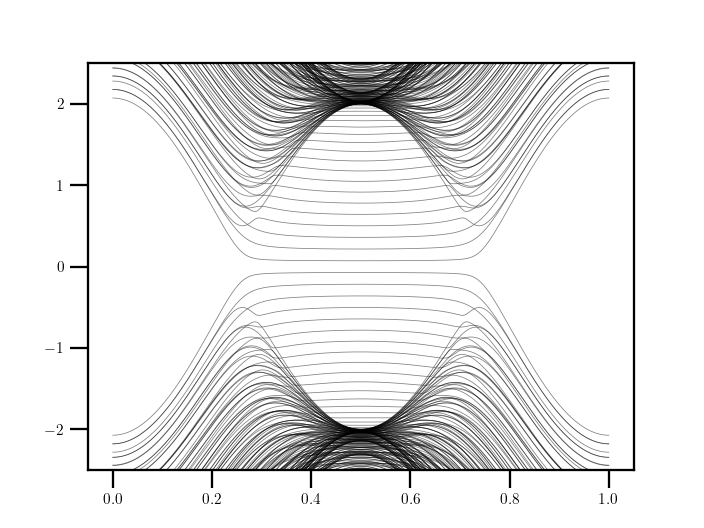

In [51]:
for h in range(len(Ek2)):
    plt.plot(k_dist, Ek2[h,:],alpha=0.5, color="black", linewidth=0.5)
ylim(-2.5,2.5)
savefig("2D-StarinedWSM_n={0}".format(n))

In [37]:
%matplotlib notebook
%matplotlib notebook

In [397]:
X,Y,Z = dot( NYZ_WSM.get_orb(), NYZ_WSM.get_lat() ).T

In [422]:
prob=IPR(ψ2)
shape(prob)
prob
print(shape(Z),shape(prob))


(242,) (882,)


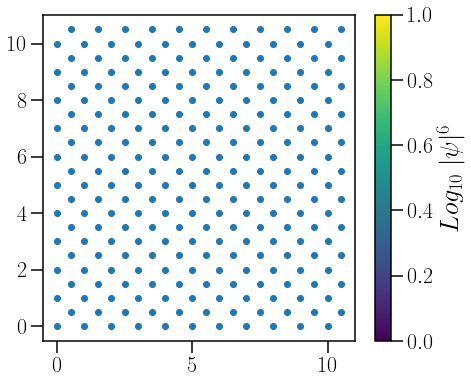

In [419]:
fig,ax = plt.subplots(figsize=(7,6))
colores = ["r", "b", "g"]
# ax.scatter(X,Y,c="blue")
triang = ax.scatter(Z,Y)
# ax.set_xlim(-1,15)
# ax.selt_ylim(-1,15)
plt.colorbar(triang,ax=ax,label="$Log_{10}\;|\psi|^6$")


<IPython.core.display.Javascript object>


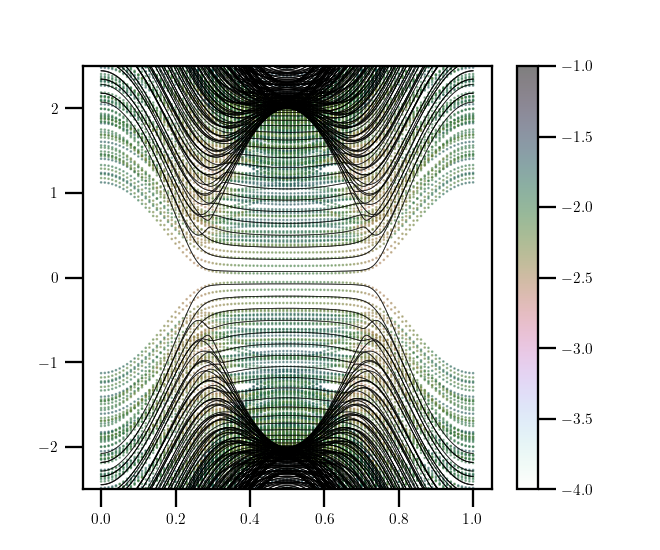

(-2.0, 2.0)

In [43]:
fig,ax  = plt.subplots(ncols=1,nrows=1,figsize=(6,5))
for n in range(0, len(Ek2)):
    Ekval=Ek2[n,:]
    amp  =Ik1s[n,:]
    cmap=ax.scatter(k_dist,Ekval,c =log10(amp), vmin=-4,vmax=-1, cmap = 'cubehelix_r',s = 0.5, alpha=0.5,rasterized=True)
fig.colorbar(cmap)
ax.set_ylim(-2,2)

In [47]:
Ik1s.min()

0.009915606936826384

<IPython.core.display.Javascript object>


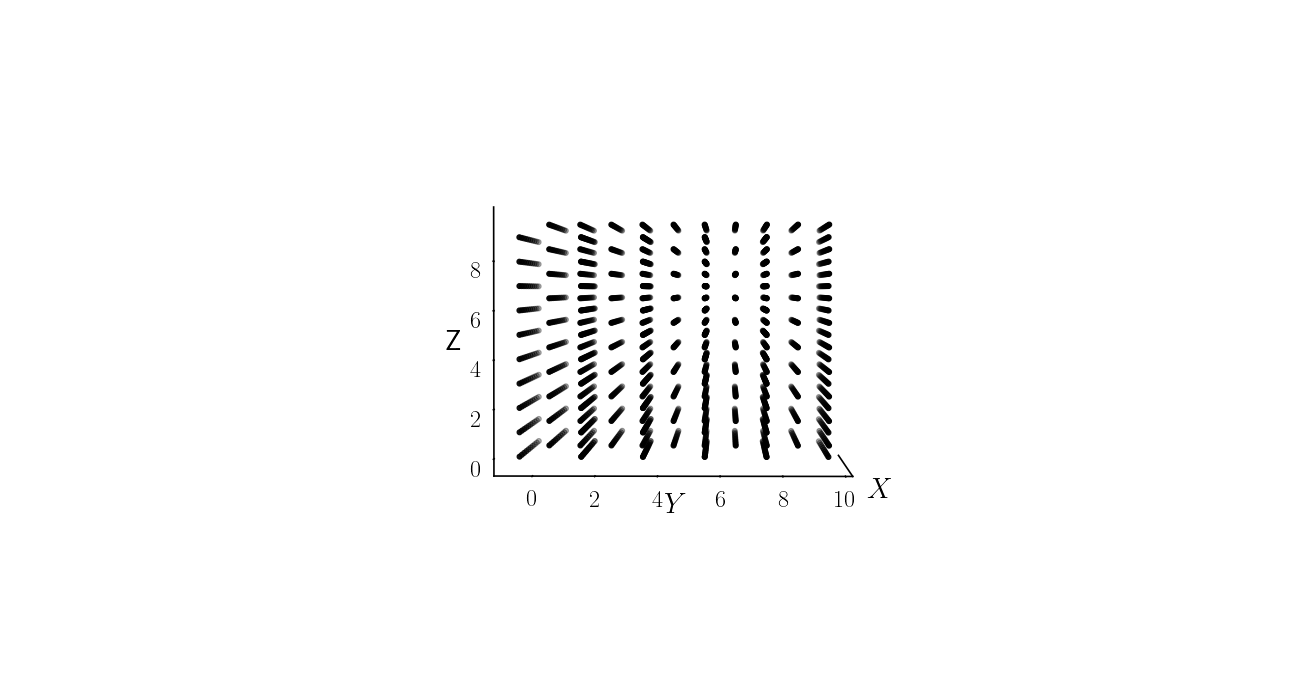

In [140]:
L=10

Xs,Ys,Zs = dot( NYZX_WSM.get_orb(), NYZX_WSM.get_lat() ).T
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xs,Ynew,Zs,c="black")

# ax.scatter(X,Y,Z)
ax.set_xlabel("$X$")
ax.set_ylabel("$Y$")
ax.set_zlabel("Z")


# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
eformada

<IPython.core.display.Javascript object>


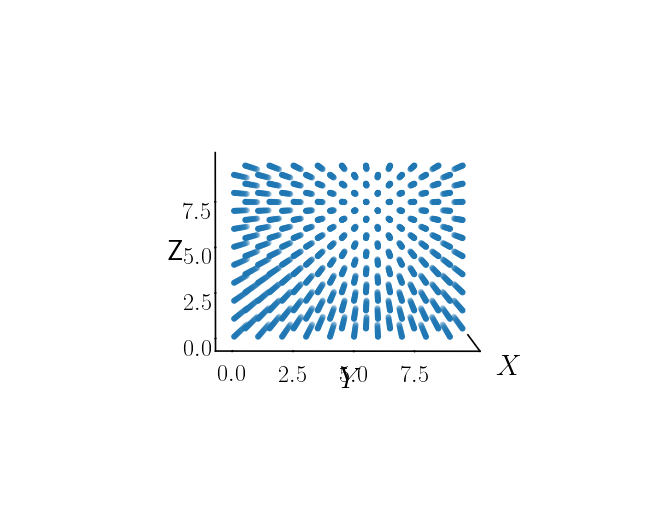

In [143]:
L=10

Xs,Ys,Zs = dot( NYZX_WSM.get_orb(), NYZX_WSM.get_lat() ).T
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(Xs,Ynew,Zs,c="black")

ax.scatter(Xs,Ys,Zs)
ax.set_xlabel("$X$")
ax.set_ylabel("$Y$")
ax.set_zlabel("Z")


# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.view_init(1, 1)
ax.set_xticks([])
savefig("Lattice_normal.pdf")

In [77]:
L=10
Y_normal = WSH.cut_piece(L,1,glue_edgs=False)
NYZ_WSM  = Y_normal.cut_piece(L,2,glue_edgs=False)
NYZXn_WSM = NYZ_WSM.cut_piece(L,0,glue_edgs=False)

In [78]:
X,Y,Z = dot( NYZXn_WSM.get_orb(), NYZXn_WSM.get_lat() ).T

In [70]:
from mpl_toolkits.mplot3d import axes3d

<IPython.core.display.Javascript object>


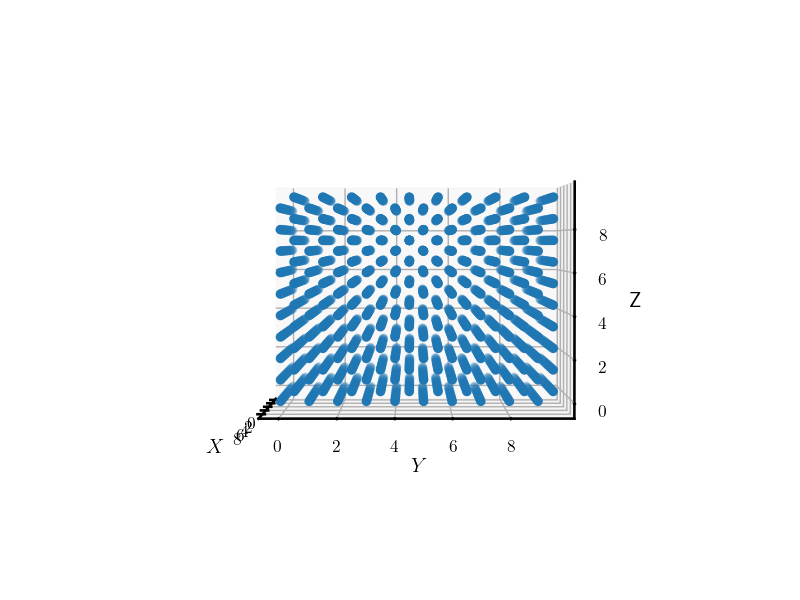

Text(0.5, 0, 'Z')

In [71]:
fig = plt.figufig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z)
ax.set_xlabel("$X$")
ax.set_ylabel("$Y$")
ax.set_zlabel("Z")
re()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z)
ax.set_xlabel("$X$")
ax.set_ylabel("$Y$")
ax.set_zlabel("Z")


In [135]:
%matplotlib notebook
%matplotlib notebook


In [ ]:
L=10

NYZ_WSM  = NY_WSM.cut_piece(L,2,glue_edgs=False)
NYZXn_WSM = NYZ_WSM.cut_piece(L,0,glue_edgs=False)
X,Y,Z = dot( NYZXn_WSM.get_orb(), NYZXn_WSM.get_lat() ).T
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z)
ax.set_xlabel("$X$")
ax.set_ylabel("$Y$")
ax.set_zlabel("Z")
